In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy import ndimage

import astra

import odl
import odl.tomo

from numba import jit

import time


Bad key "text.kerning_factor" on line 4 in
/home/davide.evangelista/anaconda3/envs/tomo/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def add_gaussian_noise(proj_data, noise_level=0.01):
    # Generiamo il rumore eta
    noise = np.random.normal(size=proj_data.shape) # random gaussian distribution
    noise /= np.linalg.norm(noise.flatten(), 2) # norma di frobenius
    noise *= noise_level * np.linalg.norm(proj_data.flatten(), 2)

    proj_data += noise

    return proj_data

In [3]:
# --- Set up geometry of the problem --- #


# Reconstruction space: discretized functions on the rectangle
# [-20, 20]^2 with 300 samples per dimension.
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[512, 512], dtype='float32')

# Angles
angle_partition = odl.uniform_partition(0, np.pi, 180)

# Detector
detector_partition = odl.uniform_partition(-80, 80, 1024)

# Geometry
geometry = odl.tomo.FanFlatGeometry(angle_partition, detector_partition, src_radius=1000, det_radius=800)

# Ray transform (= forward projection).
ray_trafo = odl.tomo.RayTransform(reco_space, geometry)

# Define FBP Operator
fbp = odl.tomo.fbp_op(ray_trafo, filter_type='Hann', frequency_scaling=1)

In [4]:
def f(x):
    x = np.reshape(x, (m, n))
    proj = ray_trafo(x).asarray()

    return 0.5 * (np.linalg.norm(proj - b, 'fro')**2 + param_reg * TV(x))

def grad_f(x):
    x = np.reshape(x, (m, n))
    proj = ray_trafo(x).asarray()
    grad = ray_trafo.adjoint(proj - b).asarray()

    return np.reshape(grad + param_reg * x, m*n)

def V_LS(x):
    x = np.reshape(x, (m, n))
    return ray_trafo.adjoint(ray_trafo(x)).asarray()

def U_LS(x):
    x = np.reshape(x, (m, n))
    return ray_trafo.adjoint(b).asarray()

def diff(x, axis, append=0):
    m, n = x.shape
    y = np.zeros((m+1, n+1))
    y[:-1, :-1] = x
    
    if axis == 0:
        for i in range(m):
            x[i, :] = y[i+1, :-1] - y[i, :-1]
    elif axis == 1:
        for j in range(n):
            x[:, j] = y[:-1, j+1] - y[:-1, j]
    else:
        return None
    return x

def D_h(x):
    x = np.reshape(x, (m, n))
    return np.diff(x, axis=1, append=0)

def D_v(x):
    x = np.reshape(x, (m, n))
    return np.diff(x, axis=0, append=0)

def phi(t, beta=1e-3):
    return 2 * np.sqrt(t + beta ** 2)

def dphi(t, beta=1e-3):
    return 1 / np.sqrt(t + beta ** 2)

def delta(x):
    return np.square(D_h(x)) + np.square(D_v(x))

def V_TV(x, beta=1e-3): # Zero padding
    x = np.reshape(x, (m, n))
    V_tv = np.zeros((m, n))
    D = delta(x)

    V_tv[0, 0] = (2 * dphi(D[0, 0]) + dphi(x[0, 0]) + dphi(x[0, 0])) * x[0, 0]
    for j in range(1, n):
        V_tv[0, j] = (2 * dphi(D[0, j]) + dphi(x[0, j]) + dphi(D[0, j-1])) * x[0, j]
    for i in range(1, m):
        V_tv[i, 0] = (2 * dphi(D[i, 0]) + dphi(D[i-1, 0]) + dphi(x[i, 0])) * x[i, 0]

    for i in range(1, m):
        for j in range(1, n):
            V_tv[i, j] = (2 * dphi(D[i, j]) + dphi(D[i-1, j]) + dphi(D[i, j-1])) * x[i, j]

    return V_tv

def U_TV(x, beta=1e-3): # Zero padding
    x = np.reshape(x, (m, n))
    U_tv = np.zeros((m, n))
    D = delta(x)

    U_tv[0, 0] = dphi(D[0, 0]) * (x[1, 0] + x[0, 1])
    for j in range(1, n-1):
        U_tv[0, j] = dphi(D[0, j]) * (x[1, j] + x[0, j+1]) + dphi(D[0, j-1]) * x[0, j-1]
    U_tv[0, n-1] = dphi(D[0, n-1]) * x[1, n-1] + dphi(D[0, n-2]) * x[0, n-2] 
    for i in range(1, m-1):
        U_tv[i, 0] = dphi(D[i, 0]) * (x[i+1, 0] + x[i, 1]) + dphi(D[i-1, 0]) * x[i-1, 0]
    U_tv[m-1, 0] = dphi(D[m-1, 0]) * x[m-1, 1] + dphi(D[m-2, 0]) * x[m-2, 0]

    for i in range(1, m-1):
        for j in range(1, n-1):
            U_tv[i, j] = dphi(D[i, j]) * (x[i+1, j] + x[i, j+1]) + dphi(D[i-1, j]) * x[i-1, j] + dphi(D[i, j-1]) * x[i, j-1]

    return U_tv

def TV(x, beta=1e-3):
    Dh = D_h(x)
    Dv = D_v(x)

    return np.sum(np.sqrt(np.square(Dh) + np.square(Dv) + beta ** 2))

def compute_scaling(x, V_LS, V_TV, rho):
    V = V_LS + param_reg * V_TV
    V = np.reshape(V, m*n)
    x = np.reshape(x, m*n)

    d = np.zeros(m*n)
    for i in range(m*n):
        if V[i] < 1e-4:
            V[i] = 1e-4
        if rho == 0:
            d[i] = x[i]/V[i]
        else:
            d[i] = min(rho, max(1/rho, x[i]/V[i]))
    return d

def backtracking(x, f, grad):
    alpha = 1
    rho = 0.8
    c1 = 0.25

    fx = f(x)
    while f(x - alpha * grad) > fx - alpha * c1 * grad.dot(grad):
        alpha *= rho

    return alpha

def bb(s, x0, x, grad_0, grad, alpha_old):
    alpha_min = 1e-10
    alpha_max = 1e5

    s_k = x - x0
    z_k = grad - grad_0

    Dz = z_k * s

    alpha_bb1_denom = np.dot(s_k, z_k / s)
    alpha_bb2_num = np.dot(s_k, Dz)

    if alpha_bb1_denom <= 0:
        alpha_bb1 = min(10 * alpha_old, alpha_max)
    else:
        alpha_bb1 = np.linalg.norm(s_k / s, 2)**2 / alpha_bb1_denom
        alpha_bb1 = max(min(alpha_bb1, alpha_max), alpha_min)

    if alpha_bb2_num <= 0:
        alpha_bb2 = min(10 * alpha_old, alpha_max)
    else:
        alpha_bb2 = alpha_bb2_num / (np.linalg.norm(Dz, 2) ** 2)
        alpha_bb2 = max(min(alpha_bb2, alpha_max), alpha_min)

    global alpha_bb2_vec
    alpha_bb2_vec = np.append(alpha_bb2_vec, alpha_bb2)

    global tau_bb
    if alpha_bb2 / alpha_bb1 < tau_bb:
        alpha = np.min(alpha_bb2_vec[-m_bb-1:])
        tau_bb = tau_bb * 0.9
    else:
        alpha = alpha_bb1
        tau_bb = tau_bb * 1.1

    return alpha

def Proj_positive(x):
    x = np.reshape(x, m*n)
    for i in range(len(x)):
        x[i] = max(0, x[i])
    return x

def gradient_descent(x0, maxit, tol_grad, x_true):
    x = x0
    grad = grad_f(x)
    err_list = np.zeros(maxit) #errore alla k-esima iterazione
    grad_list = np.zeros(maxit)

    k = 0
    while (np.linalg.norm(grad) > tol_grad) and (k < maxit):
        alpha = backtracking(x, f, grad)
        print('Iter: ', k, '\t Alpha: ', alpha, '\n')
        x = x - alpha * grad
        grad = grad_f(x)

        err_list[k] = np.linalg.norm(x - x_true, 2) / np.linalg.norm(x_true, 2)
        grad_list[k] = np.linalg.norm(grad, 2)
        k += 1

    err_list = err_list[0:k+1]
    grad_list = grad_list[0:k+1]

    return(x, k, grad_list, err_list)


def sgp(x0, maxit, tol_grad, alpha=1):
    x0 = np.reshape(x0, m*n)
    global alpha_bb2_vec 
    alpha_bb2_vec = np.array([alpha] * m_bb)
    x = x0
    err_list = np.zeros(maxit+1) #errore alla k-esima iterazione
    grad_list = np.zeros(maxit+1)
    fun_list = np.zeros(maxit+1)

    u_ls = np.reshape(U_LS(x), m*n)
    v_ls = np.reshape(V_LS(x), m*n)
    u_tv = np.reshape(U_TV(x), m*n)
    v_tv = np.reshape(V_TV(x), m*n)
    grad = v_ls - u_ls + param_reg * (v_tv - u_tv)
    grad_list[0] = np.linalg.norm(grad, 2)

    fun_list[0] = f(x)
    err_list[0] = np.linalg.norm(x - x_true, 2) / np.linalg.norm(x_true, 2)

    rho = np.sqrt(1 + 1e15)
    s = compute_scaling(x, v_ls, v_tv, rho)

    k = 0
    CONTINUE = True
    while CONTINUE:
        #print('************* No scaling')
        # print('************* Iteration: ', k) # TO REMOVE
        desc_direction = Proj_positive(x - alpha * s * grad) - x
        step_length = 1 #backtracking(x, f, grad)
        # print('Step Length: ', step_length) # TO REMOVE

        x0 = x
        x = x + step_length * desc_direction

        k += 1
        err_list[k] = np.linalg.norm(x - x_true, 2) / np.linalg.norm(x_true, 2)
        # print('Rel Err: ', err_list[k]) # TO REMOVE
        grad_list[k] = np.linalg.norm(grad, 2)
        fun_list[k] = f(x)

        CONTINUE = (np.linalg.norm(grad) > tol_grad) and (k < maxit)
        if CONTINUE:
            v_ls = np.reshape(V_LS(x), m*n)
            u_tv = np.reshape(U_TV(x), m*n)
            v_tv = np.reshape(V_TV(x), m*n)
            grad_0 = grad
            grad = v_ls - u_ls + param_reg * (v_tv - u_tv)

            rho = np.sqrt(1 + 1e15 / (k**2.1))
            #print('Rho = ', rho, '\t 1/Rho = ', 1/rho)
            s = compute_scaling(x, v_ls, v_tv, rho)
            #print('S_max = ', np.max(s), '\t S_min = ', np.min(s))
            alpha = bb(s, x0, x, grad_0, grad, alpha)
            # print('Alpha BB: ', alpha) # TO REMOVE

    err_list = err_list[0:k+1]
    grad_list = grad_list[0:k+1]
    fun_list = fun_list[0:k+1]

    return(x, k, grad_list, err_list, fun_list)

In [5]:
Proj_positive = jit(nopython=True)(Proj_positive)
compute_scaling = jit(nopython=True)(compute_scaling)

diff = jit()(diff)
dphi = jit()(dphi)
delta = jit()(delta)
D_h = jit()(D_h)
D_v = jit()(D_v)
V_TV = jit()(V_TV)
U_TV = jit()(U_TV)

In [20]:
import os
from skimage import filters
from skimage.metrics import structural_similarity as ssim

import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, psnr, fsim, issm, uiq

def evaluate(x_true, x_corr, metric):
    N = x_true.shape[0]
    m = 0
    for i in range(N):
        try:
            m += metric(x_true[i, :, :, 0], x_corr[i, :, :, 0])
        except:
            m += metric(x_true[i, :, :, :], x_corr[i, :, :, :])
    return m / N

def get_test_name(path):
    n_list = []
    for name in os.listdir(path):
        n_list.append(path + name)
        
    return n_list

def relative_error(x_true, x_corr):
    return np.linalg.norm(x_true - x_corr, 'fro') / np.linalg.norm(x_true, 'fro')


true_path = './Test/C081/'
corr_path = './Test/C081_SGP_Test4/'

true_path = get_test_name(true_path)
corr_path = get_test_name(corr_path)

true_path.sort()
corr_path.sort()

N = len(true_path)
rel_err = 0

for i in range(N):
    x_true = np.load(true_path[i])
    m, n = x_true.shape

    # Parametri per l'algoritmo
    param_reg = 5e-5
    maxit = 30
    tol_grad = 1e-8
    tau_bb = 0.5
    m_bb = 3
    x0 = np.ones((m, n)) / (m*n)

    # Creazione problema test
    sinogram = ray_trafo(x_true)
    sinogram = sinogram.asarray()

    # Dato finale b
    b = add_gaussian_noise(sinogram, 0.01)

    # Chiamata al solver SGP
    x_true = np.reshape(x_true, m*n)
    x, k, grad_list, err_list, fun_list = sgp(x0, maxit, tol_grad)
    
    rel_err += err_list[-1]
    
    print(i)

0
1
2


KeyboardInterrupt: 

In [15]:
print(rel_err / N)

# Test3
# 
# lambda = 5e-3 -> 0.108087
# lambda = 5e-2 -> 0.133389
# lambda = 5e-4 -> 0.107668
# lambda = 5e-5 -> 0.107729

0.10772925431


In [20]:
np.save('xCAT_SGP_36.npy', x.reshape((512, 512)))

In [9]:
x_true = np.load('./FDCT/C030/121.npy')
m, n = x_true.shape

# Parametri per l'algoritmo
param_reg = 1e-2
maxit = 400
tol_grad = 1e-8
tau_bb = 0.5
m_bb = 3
x0 = np.ones((m, n)) / (m*n)

# Creazione problema test
sinogram = ray_trafo(x_true)
sinogram = sinogram.asarray()

# Dato finale b
b = add_gaussian_noise(sinogram, 0.01)

# Chiamata al solver SGP
x_true = np.reshape(x_true, m*n)
x, k, grad_list, err_list, fun_list = sgp(x0, maxit, tol_grad)

print('**************')
print('Relative Error: ', err_list[-1])
print('Gradient: ', grad_list[-1])
print('Function: ', fun_list[-1])
print('**************')

**************
Relative Error:  0.115861242734
Gradient:  4.83013515962
Function:  291.307029294
**************


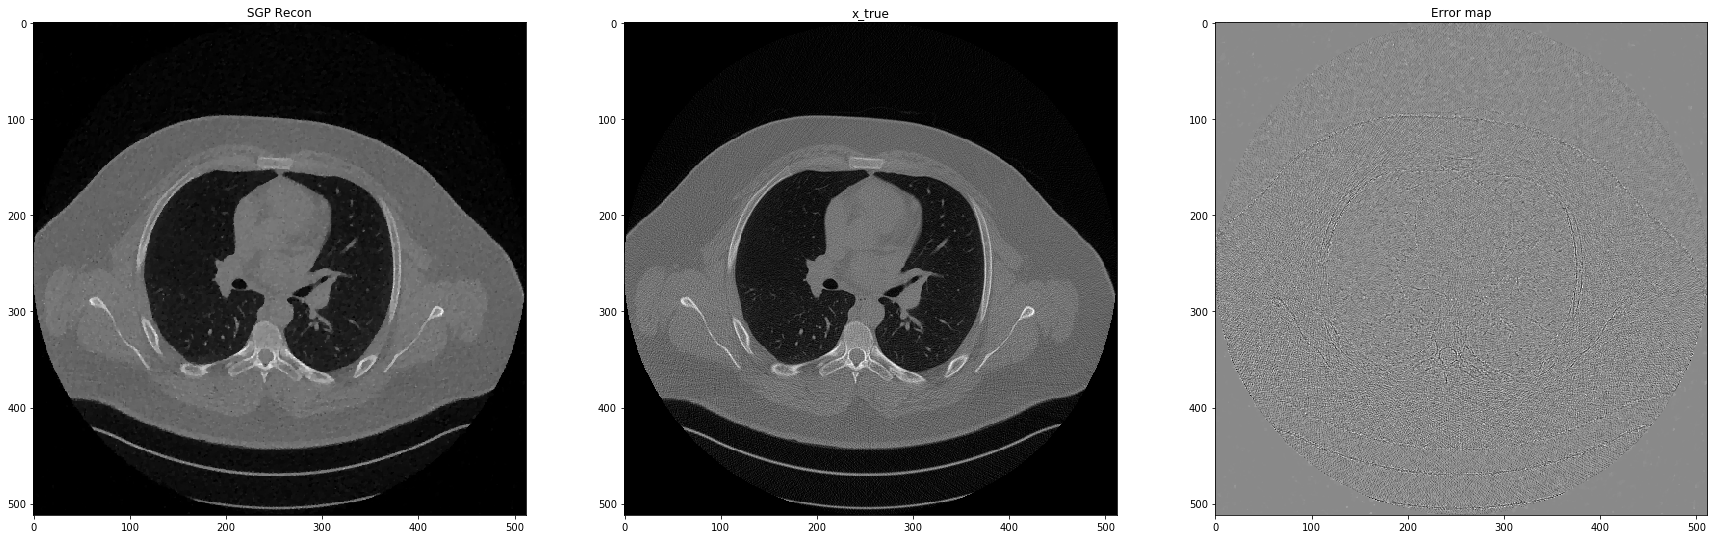

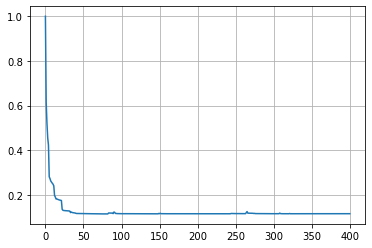

Rel. Err. 0.115861242734
SSIM: 0.84565210388
Min/Max: 0.0 0.999826244765


/home/davide.evangelista/anaconda3/envs/tomo/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


In [10]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.imshow(x.reshape(512, 512))
plt.title('SGP Recon')
plt.gray()

plt.subplot(1, 3, 2)
plt.imshow(x_true.reshape(512, 512), vmin=0, vmax=1)
plt.title('x_true')
plt.gray()

plt.subplot(1, 3, 3)
plt.imshow(x.reshape(512, 512) - x_true.reshape(512, 512))
plt.title('Error map')
plt.gray()

plt.savefig('SGP_8.png')
plt.show()

plt.plot(err_list)
plt.grid()

plt.show()
from skimage.measure import compare_ssim as ssim
x = x.reshape(512, 512)
x_true = x_true.reshape(512, 512)

print('Rel. Err.', np.linalg.norm(x_true - x, 'fro') / np.linalg.norm(x_true, 'fro'))
print('SSIM:', ssim(x, x_true))
print('Min/Max:', x.min(), x.max())

np.save('test.npy', x)

In [19]:
import matplotlib as mpl
mpl.image.imsave('Testc_500Iter.png', x, cmap='gray')

In [18]:
def get_projection_operator():
    # create geometries and projector
    proj_geom = astra.create_proj_geom('fanflat', 1.0, 1024, np.linspace(0, 2*np.pi, 360), 1800, 500)
    vol_geom = astra.create_vol_geom(512, 512)
    proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

    print(astra.projector.is_cuda(proj_id))

    return astra.OpTomo(proj_id)

A = get_projection_operator()

x_true = x_true.flatten()
x_true = x_true / x_true.max()

s = A*x_true
noisy_s = add_gaussian_noise(s, 0.01)

x_FBP = A.reconstruct('FBP_CUDA', noisy_s)
x_FBP = x_FBP.reshape((512, 512))

True


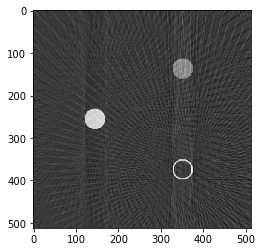

In [30]:
plt.imshow(x_FBP)
plt.gray()
plt.show()

np.save('./sintetica_FBP.npy', x_FBP.reshape(512, 512))

In [36]:
"""
Build the dataset.
"""
def get_output_path(path):
    out_path = './SGP_180_180' + path[6:]

    return out_path


def read_img(path):
    return np.load(path)


def get_name_list(path):
    import os
    n_list = []
    for patient in os.listdir(path):
        count = 0
        for slice_id in os.listdir(path + patient):
            n_list.append(path + patient + '/' + str(count) + '.npy')
            count += 1
    
    return n_list


def add_gaussian_noise(proj_data, noise_level=0.01):
    # Generiamo il rumore eta
    noise = np.random.normal(size=proj_data.shape) # random gaussian distribution
    noise /= np.linalg.norm(noise.flatten(), 2) # norma di frobenius
    noise *= noise_level * np.linalg.norm(proj_data.flatten(), 2)

    proj_data += noise

    return proj_data


# Get the list of file name
n_list = get_name_list('./FDCT/')


# Start Iterations!
for i, img_name in enumerate(n_list):
    print(i, '-', img_name)
    out_path = get_output_path(img_name)
    x_true = read_img(img_name)
    x_true = x_true / x_true.max()
    
    x0 = np.ones((m, n)) / (m*n)

    # Creazione problema test
    sinogram = ray_trafo(x_true)
    sinogram = sinogram.asarray()
    
    # Dato finale b
    b = add_gaussian_noise(sinogram, 0.01)
    
    # Chiamata al solver SGP
    x_true = np.reshape(x_true, m*n)
    x, k, grad_list, err_list, fun_list = sgp(x0, maxit, tol_grad)
    x = x.astype('float32')
    
    np.save(out_path, x)

0 - ./FDCT/C050/0.npy
1 - ./FDCT/C050/1.npy
2 - ./FDCT/C050/2.npy
3 - ./FDCT/C050/3.npy
4 - ./FDCT/C050/4.npy
5 - ./FDCT/C050/5.npy
6 - ./FDCT/C050/6.npy
7 - ./FDCT/C050/7.npy
8 - ./FDCT/C050/8.npy
9 - ./FDCT/C050/9.npy
10 - ./FDCT/C050/10.npy
11 - ./FDCT/C050/11.npy
12 - ./FDCT/C050/12.npy
13 - ./FDCT/C050/13.npy
14 - ./FDCT/C050/14.npy
15 - ./FDCT/C050/15.npy
16 - ./FDCT/C050/16.npy
17 - ./FDCT/C050/17.npy
18 - ./FDCT/C050/18.npy
19 - ./FDCT/C050/19.npy
20 - ./FDCT/C050/20.npy
21 - ./FDCT/C050/21.npy
22 - ./FDCT/C050/22.npy
23 - ./FDCT/C050/23.npy
24 - ./FDCT/C050/24.npy
25 - ./FDCT/C050/25.npy
26 - ./FDCT/C050/26.npy
27 - ./FDCT/C050/27.npy
28 - ./FDCT/C050/28.npy
29 - ./FDCT/C050/29.npy
30 - ./FDCT/C050/30.npy
31 - ./FDCT/C050/31.npy
32 - ./FDCT/C050/32.npy
33 - ./FDCT/C050/33.npy
34 - ./FDCT/C050/34.npy
35 - ./FDCT/C050/35.npy
36 - ./FDCT/C050/36.npy
37 - ./FDCT/C050/37.npy
38 - ./FDCT/C050/38.npy
39 - ./FDCT/C050/39.npy
40 - ./FDCT/C050/40.npy
41 - ./FDCT/C050/41.npy
42 - ./FDCT/

In [25]:
for i, img_name in enumerate(n_list):
    print(i, '-', img_name)
    out_path = get_output_path(img_name)
    x_true = read_img(out_path)
    
    np.save(out_path, x_true.reshape(512, 512))

0 - ./FDCT/C050/0.npy
1 - ./FDCT/C050/1.npy
2 - ./FDCT/C050/2.npy
3 - ./FDCT/C050/3.npy
4 - ./FDCT/C050/4.npy
5 - ./FDCT/C050/5.npy
6 - ./FDCT/C050/6.npy
7 - ./FDCT/C050/7.npy
8 - ./FDCT/C050/8.npy
9 - ./FDCT/C050/9.npy
10 - ./FDCT/C050/10.npy
11 - ./FDCT/C050/11.npy
12 - ./FDCT/C050/12.npy
13 - ./FDCT/C050/13.npy
14 - ./FDCT/C050/14.npy
15 - ./FDCT/C050/15.npy
16 - ./FDCT/C050/16.npy
17 - ./FDCT/C050/17.npy
18 - ./FDCT/C050/18.npy
19 - ./FDCT/C050/19.npy
20 - ./FDCT/C050/20.npy
21 - ./FDCT/C050/21.npy
22 - ./FDCT/C050/22.npy
23 - ./FDCT/C050/23.npy
24 - ./FDCT/C050/24.npy
25 - ./FDCT/C050/25.npy
26 - ./FDCT/C050/26.npy
27 - ./FDCT/C050/27.npy
28 - ./FDCT/C050/28.npy
29 - ./FDCT/C050/29.npy
30 - ./FDCT/C050/30.npy
31 - ./FDCT/C050/31.npy
32 - ./FDCT/C050/32.npy
33 - ./FDCT/C050/33.npy
34 - ./FDCT/C050/34.npy
35 - ./FDCT/C050/35.npy
36 - ./FDCT/C050/36.npy
37 - ./FDCT/C050/37.npy
38 - ./FDCT/C050/38.npy
39 - ./FDCT/C050/39.npy
40 - ./FDCT/C050/40.npy
41 - ./FDCT/C050/41.npy
42 - ./FDCT/

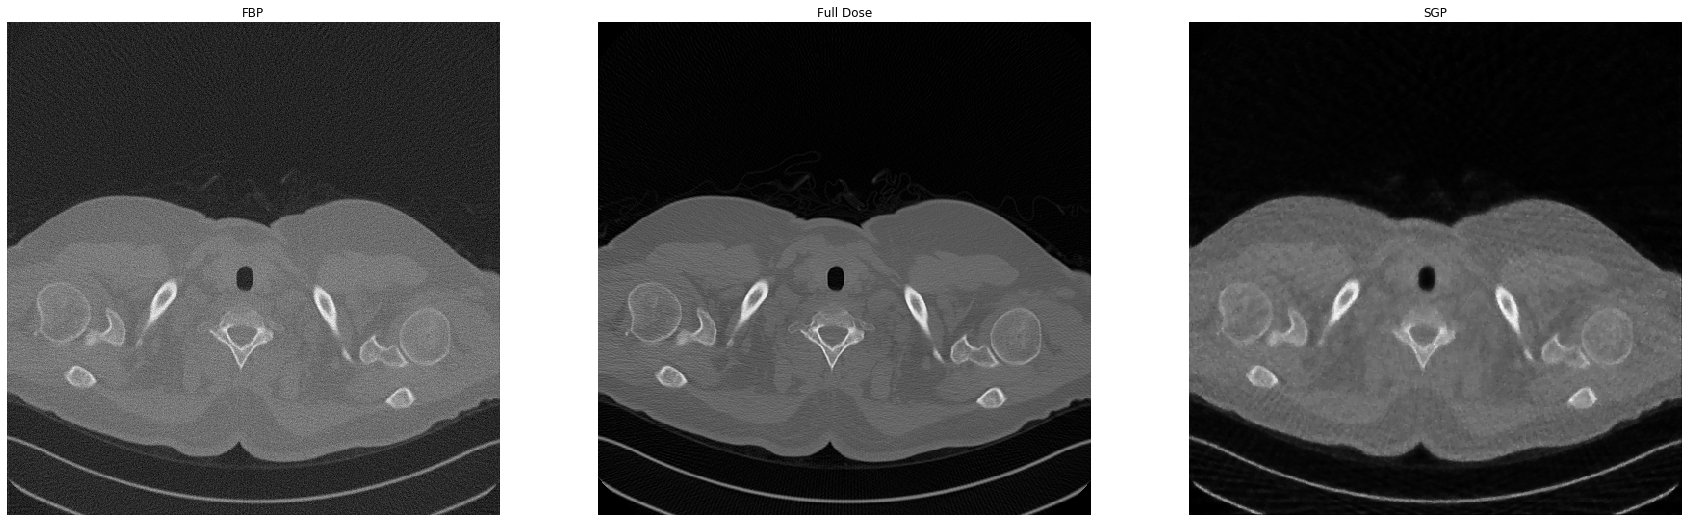

In [21]:
patient_id = 'C002'
slice_id = '0'

x_true = np.load('./FDCT/' + patient_id + '/' + slice_id + '.npy')
x_fbp = np.load('./FACT30/' + patient_id + '/' + slice_id + '.npy')
x_sgp = np.load('./SGP_180_60/' + patient_id + '/' + slice_id + '.npy')

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.imshow(x_fbp)
plt.title('FBP')
plt.axis('off')
plt.gray()

plt.subplot(1, 3, 2)
plt.imshow(x_true)
plt.title('Full Dose')
plt.axis('off')
plt.gray()

plt.subplot(1, 3, 3)
plt.imshow(x_sgp)
plt.title('SGP')
plt.axis('off')
plt.gray()

plt.savefig("test_confronto_id_" + patient_id + '_' + slice_id + '.png')
plt.show()